## Manipulación Simbólica en Julia

Usaremos el paquete `Symbolics.jl`. 

Es un paquete nuevo y sujeto a cambios drásticos!

In [1]:
#import Pkg; 
#Pkg.add("Symbolics")
#Pkg.add("Latexify")
using Symbolics
using Latexify
using Plots

Las variables se define con el macro `@variables`

In [3]:
@variables x y w[1:3] A[1:5,1:6]

4-element Vector{Any}:
 x
 y
  w[1:3]
  A[1:5,1:6]

In [4]:
typeof(x)

Num

Las *operaciones* no se *hacen* sino que quedan indicadas. Es una forma similar a la que se usa para indicar una expresion, un árbol. 

In [5]:
z = x^2 + y

y + x^2

In [6]:
typeof(z)

Num

In [7]:
z^2

(y + x^2)^2

In [8]:
Symbolics.simplify(z^2; expand=true)

x^4 + y^2 + 2y*(x^2)

In [9]:
Symbolics.simplify(z^2)

(y + x^2)^2

Podemos trabajar también con matrices o arrays arbitrarios. 

In [10]:
A = [x^2 + y 0 2x
     0       1 2y
     y^2 + x 0 0]

3×3 Matrix{Num}:
 y + x^2  0  2x
       0  1  2y
 x + y^2  0   0

Se puede mejorar la manera en que las ecuaciones son mostradas con el paquete `Latexify.jl` pero para este caso no hace diferencia (en Jupyter)

In [11]:
latexify(A)

L"\begin{equation}
\left[
\begin{array}{ccc}
y + x^{2} & 0 & 2 x \\
0 & 1 & 2 y \\
x + y^{2} & 0 & 0 \\
\end{array}
\right]
\end{equation}
"

In [13]:
using SparseArrays
spA = sparse(A)
@show spA

spA = sparse([1, 3, 2, 1, 2], [1, 1, 2, 3, 3], Num[y + x^2, x + y^2, 1, 2x, 2y], 3, 3)


3×3 SparseMatrixCSC{Num, Int64} with 5 stored entries:
 y + x^2  ⋅  2x
       ⋅  1  2y
 x + y^2  ⋅   ⋅

Podemos calcular algunas inversas no muy complicadas.

In [14]:
A_inv = inv(A)

3×3 Matrix{Num}:
                                                      0  …  (-((-(y + x^2)) / (x + y^2))) / (y + x^2)
                                               -(y / x)             -((-y*(y + x^2)) / (x*(x + y^2)))
 ((x + y^2) / (y + x^2)) / ((2x*(x + y^2)) / (y + x^2))             -1 / ((2x*(x + y^2)) / (y + x^2))

In [15]:
Idd = A * A_inv

3×3 Matrix{Num}:
 1  0.0                                                    0
 0  1.0                                                    0
 0  0.0  (-(x + y^2)*((-(y + x^2)) / (x + y^2))) / (y + x^2)

Para encontrar la identidad debemos usar la función `simplify()`, la cual aplicamos a cada elemento con la notación usual de agregar un .

In [18]:
Symbolics.simplify.(Idd)

3×3 Matrix{Num}:
 1  0.0  0
 0  1.0  0
 0  0.0  1

También podemos hacer sustituciones. La función `substitute()` admite un diccionario con las sustituciones que queremos hacer.

In [19]:
r = x^2 + y^2
@variables θ
Symbolics.substitute(r, Dict([x =>sin(θ)]))

y^2 + sin(θ)^2

In [20]:
trig = Dict([x => sin(θ), y => cos(θ)])

Dict{Num, Num} with 2 entries:
  y => cos(θ)
  x => sin(θ)

In [21]:
Symbolics.substitute(r,trig)

cos(θ)^2 + sin(θ)^2

In [22]:
Symbolics.simplify(Symbolics.substitute(r,trig))

1

In [26]:
latexify((x + im*y)^2)

L"\begin{equation}
x^{2} - y^{2} + 2 x y i
\end{equation}
"

In [29]:
f(t) = (t >=0)*1 + (t<0)*2

f (generic function with 1 method)

In [30]:
f(x)

2(x < 0) + x >= 0

### Derivadas: 

Calculemos un gradiente:

In [31]:
@variables s[1:3] p[1:3]
ss = Symbolics.scalarize(s)
ps = Symbolics.scalarize(p)

3-element Vector{Num}:
 p[1]
 p[2]
 p[3]

In [32]:
h(u,t) = u'*u - t'*u

h (generic function with 1 method)

In [33]:
Symbolics.gradient(h(ss,ps),ss)

3-element Vector{Num}:
 2s[1] - p[1]
 2s[2] - p[2]
 2s[3] - p[3]

Calculemos un Jacobiano:

In [34]:
function f(u,p)
  [p[1]*u[1] - u[3]; u[1]^2 - u[2]; u[3] + cos(u[2])]
end

#@register_symbolics cos(x) 

f (generic function with 2 methods)

In [36]:
f([1;2;3.],[4;5;6])

3-element Vector{Float64}:
  1.0
 -1.0
  2.5838531634528574

In [37]:
f([x, y, z],p) # Recall that z = x^2 + y

3-element Vector{Num}:
 x*p[1] - y - (x^2)
            x^2 - y
   y + x^2 + cos(y)

In [39]:
f(ss,ps)

3-element Vector{Num}:
 p[1]*s[1] - s[3]
    s[1]^2 - s[2]
 cos(s[2]) + s[3]

In [40]:
Jfs = Symbolics.jacobian(f(ss,ps), ss)

3×3 Matrix{Num}:
  p[1]           0  -1
 2s[1]          -1   0
     0  -sin(s[2])   1

### Generando una función numérica

In [41]:
Jfs_exp = Symbolics.build_function(Jfs,s, p);
Jfs_f = eval(Jfs_exp[1]);

In [45]:
Jfs_f(ss,ps)

3×3 Matrix{Num}:
  p[1]           0  -1
 2s[1]          -1   0
     0  -sin(s[2])   1

In [44]:
dump(Jfs_exp);

Tuple{Expr, Expr}
  1: Expr
    head: Symbol function
    args: Array{Any}((2,))
      1: Expr
        head: Symbol tuple
        args: Array{Any}((2,))
          1: Symbol s
          2: Symbol p
      2: Expr
        head: Symbol block
        args: Array{Any}((4,))
          1: LineNumberNode
            line: Int64 349
            file: Symbol /Users/reula/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl
          2: LineNumberNode
            line: Int64 350
            file: Symbol /Users/reula/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl
          3: LineNumberNode
            line: Int64 351
            file: Symbol /Users/reula/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl
          4: Expr
            head: Symbol block
            args: Array{Any}((2,))
              1: LineNumberNode
                line: Int64 444
                file: Symbol /Users/reula/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl
              2: Expr
                head: Symbol call
           

In [42]:
Jfs_f([1.;2.;3], [4.;5;6])

3×3 Matrix{Float64}:
 4.0   0.0       -1.0
 2.0  -1.0        0.0
 0.0  -0.909297   1.0

**Se pueden generar funciones muy eficientes, por ejemplo construidas con paralelismo incluido.**

### Una aplicación:

Vamos a usar el método de Newton pero de forma symbólica.

In [46]:
function NR_one_step(f, Jf, x0, par)
    return x0 - Jf(x0,par)\f(x0,par)
end

NR_one_step (generic function with 1 method)

In [47]:
function my_sqrt(p,par)
    x0, N = par
    f(x,y) = x^2 - y
    Jf(x,y) = 2x
    x = x0
    for i ∈ 1:N
        x = NR_one_step(f,Jf,x,p)
    end
    return x
end

my_sqrt (generic function with 1 method)

In [51]:
par = (1.,4)
my_sqrt(4,par) - 2

9.2922294747666e-8

In [52]:
@variables v

1-element Vector{Num}:
 v

In [53]:
par = (1, 3)
my_sqrt(v,(1,3))

(1//2) + (1//2)*v + (v - (((1//2) + (1//2)*v)^2)) / ((1//1) + v) + (v - (((1//2) + (1//2)*v + (v - (((1//2) + (1//2)*v)^2)) / ((1//1) + v))^2)) / ((1//1) + v + (2v - 2(((1//2) + (1//2)*v)^2)) / ((1//1) + v))

In [54]:
k_3(v) = Symbolics.simplify(my_sqrt(v,(1,3)), expand=true)
k_3(v)

((1//8) + (1//8)*(v^4) + (3//2)*v + (19//4)*(v^2) + (3//2)*(v^3) - ((((1//2)*v - (1//4) - (1//4)*(v^2)) / ((1//1) + v))^2) - (v^2)*((((1//2)*v - (1//4) - (1//4)*(v^2)) / ((1//1) + v))^2) - (2//1)*v*((((1//2)*v - (1//4) - (1//4)*(v^2)) / ((1//1) + v))^2)) / (((1//1) + v)*((1//2) + (1//2)*(v^2) + (3//1)*v))

In [55]:
k_3_ex = Symbolics.simplify(my_sqrt(v,(1,3)))

((1//8) + (1//8)*(v^4) + (5//2)*v + (27//4)*(v^2) + (5//2)*(v^3) - ((((1//4) + (1//4)*(v^2) + (3//2)*v) / ((1//1) + v))^2) - (v^2)*((((1//4) + (1//4)*(v^2) + (3//2)*v) / ((1//1) + v))^2) - (2//1)*v*((((1//4) + (1//4)*(v^2) + (3//2)*v) / ((1//1) + v))^2)) / (((1//1) + v)*((1//2) + (1//2)*(v^2) + (3//1)*v))

Tomamos esta expresión y hacemos una función numérica:

In [56]:
k_3_exp = Symbolics.build_function(k_3_ex,v)
Base.remove_linenums!(k_3_exp)

:(function (v,)
      (/)((+)((+)((+)((+)((+)((+)((+)(1//8, (*)(1//8, (^)(v, 4))), (*)(-1//1, (^)((/)((+)((+)(1//4, (*)(1//4, (^)(v, 2))), (*)(3//2, v)), (+)(1//1, v)), 2))), (*)(5//2, v)), (*)(27//4, (^)(v, 2))), (*)(5//2, (^)(v, 3))), (*)((*)(-1//1, (^)(v, 2)), (^)((/)((+)((+)(1//4, (*)(1//4, (^)(v, 2))), (*)(3//2, v)), (+)(1//1, v)), 2))), (*)((*)(-2//1, v), (^)((/)((+)((+)(1//4, (*)(1//4, (^)(v, 2))), (*)(3//2, v)), (+)(1//1, v)), 2))), (*)((+)(1//1, v), (+)((+)(1//2, (*)(1//2, (^)(v, 2))), (*)(3//1, v))))
  end)

In [57]:
k_3_f = eval(k_3_exp)

#5 (generic function with 1 method)

In [59]:
k_3_f(2.)

1.4142156862745099

Esta no es sólo una función simbólica sino también numérica.

In [60]:
#import Pkg; Pkg.add("BenchmarkTools")
using BenchmarkTools


In [61]:
@btime k_3_f(2.)

  39.338 ns (1 allocation: 16 bytes)


1.4142156862745099

In [62]:
@btime my_sqrt(2,(1.,3))

  1.429 ns (0 allocations: 0 bytes)


1.4142156862745099

In [63]:
@btime k_3(2.)

  256.558 ns (2 allocations: 32 bytes)


1.4142156862745099

In [64]:
k_3(2) - sqrt(2)

2.1239014147411694e-6

Incluso la podemos plotear y vemos que anda muy bien para valores pequeños de la variable. 

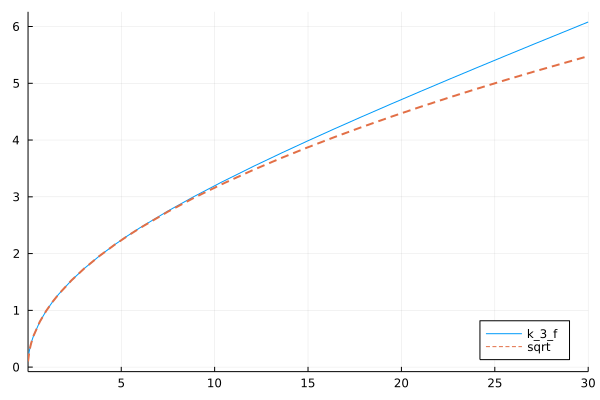

In [65]:
plt = plot(k_3_f, xlims=(0.01, 30), label="k_3_f", legend=:bottomright)
plot!(plt, sqrt, ls=:dash, label="sqrt", lw=2)

Podemos usar la función original con distintos valores de N para mejorarla. 

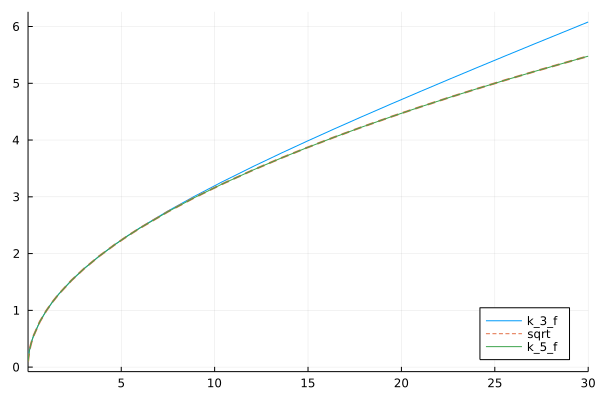

In [66]:
k_5_ex = Symbolics.simplify(my_sqrt(v,(1.,5)))
k_5_exp = Symbolics.build_function(k_5_ex,v)
k_5_f = eval(k_5_exp)

plot!(plt, k_5_f, xlims=(0.01, 30), label="k_5_f")


## NOTA: ##

En muchísimas aplicaciones se necesita calcular Jacobianos de expresiones generales que son muy complicadas o no se conocen de forma previa. Allí es donde esta librería es muy poderosa, lo mismo que otra que se llama **ForwardDiff**

In [67]:
import Pkg; Pkg.add("ForwardDiff")
using ForwardDiff

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [71]:
f(x::Vector) = sum(sin, x) + prod(tan, x) * sum(sqrt, x);

x = rand(10000) # small size for example's sake

10000-element Vector{Float64}:
 0.8012321974192579
 0.02915777009172127
 0.5007149903333755
 0.12934624576740983
 0.656861803438279
 0.8843861107091217
 0.17456283229893865
 0.0568401612739875
 0.09029513098228414
 0.3860376621555007
 0.16826339813999158
 0.7610869220224833
 0.7866913066660365
 ⋮
 0.8830421066771027
 0.1677146295522024
 0.05104719856861062
 0.03620973865932853
 0.08620231731251227
 0.9902591530852226
 0.7240902912506104
 0.7547580048577022
 0.7514517684407392
 0.4791236841031623
 0.9378446317950704
 0.08107668939578572

In [72]:
g = x -> ForwardDiff.gradient(f, x); # g = ∇f

g(x)

10000-element Vector{Float64}:
 0.6958222563384664
 0.9995749423373889
 0.8772395529789057
 0.9916464306840868
 0.7919124195077852
 0.6337644802504673
 0.9848025592584573
 0.9983850329069239
 0.9959261636929834
 0.9264082302780631
 0.9858770829879495
 0.7240867788374908
 0.7061917998483304
 ⋮
 0.6348035296975479
 0.985968837100708
 0.9986973746628882
 0.9993444990392172
 0.9962868803991677
 0.5484731834472385
 0.7491023722793644
 0.7284373583855646
 0.7306985165164893
 0.8873992465850629
 0.5915272387740025
 0.9967150852395351

In [73]:
ForwardDiff.hessian(f, x)

10000×10000 Matrix{Float64}:
 -0.718214   0.0         0.0       …   0.0        0.0        0.0
  0.0       -0.0291536   0.0           0.0        0.0        0.0
  0.0        0.0        -0.480053      0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.0        0.0         0.0       …   0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.0        0.0         0.0       …   0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  0.0        0.0         0.0           0.0        0.0        0.0
  ⋮                                ⋱                        
  0.0        0.0         0.0           0.0        0.0        0.0


### Integración: 

No existe aún. **Pero: podemos usar, por ejemplo, SymPy.jl**

In [74]:
#import Pkg; Pkg.add("SymPy")
using SymPy

Vamos al notebook SymPy_examples.ipynb

In [75]:
@vars xs
integrate(xs^2, (xs, 0, 1))

1/3